<a href="https://colab.research.google.com/github/onurburakozdemir/FIZ437E/blob/main/HW4/HW4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display

import copy
import random
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


### Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = 'drive/MyDrive/img_data'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

transform = transforms.Compose([
  transforms.RandomRotation(5),
  transforms.Resize(256),
  transforms.RandomCrop(256, padding=5),

  transforms.ToTensor(),
  transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)

len_train = round(len(dataset)*0.8)
len_test = len(dataset) - len_train

train_dataset, test_dataset = torch.utils.data.random_split(dataset, (len_train, len_test))

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
)

In [6]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 5047
Number of testing examples: 1262


### Define MLP Model

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 15)
        self.hidden_fc = nn.Linear(15, 12)
        self.output_fc = nn.Linear(12, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1)
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2

In [19]:
INPUT_DIM = 256 * 256 *3 
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM).to(device)

In [20]:
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 15]       2,949,135
            Linear-2                   [-1, 12]             192
            Linear-3                   [-1, 10]             130
Total params: 2,949,457
Trainable params: 2,949,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 0.00
Params size (MB): 11.25
Estimated Total Size (MB): 12.00
----------------------------------------------------------------


In [21]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

### MLP Train Function

In [23]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
def train(model, iterator, optimizer, criterion, device,epoch):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i,(x, y) in enumerate(iterator):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        if i%79 == 0:
            print('Epoch: [{}]/({}/{})'.format(
                epoch, i+1,len(train_dataloader)))
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### MLP Test Function

In [26]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Train Model

In [28]:
EPOCHS = 40
best_test_loss = float('inf')
mlp_train_loss = []
mlp_test_loss = []
mlp_acc_train = []
mlp_acc_test = []


for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device,epoch)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    mlp_train_loss.append(train_loss)
    mlp_acc_train.append(train_acc)

    mlp_test_loss.append(test_loss)
    mlp_acc_test.append(test_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t test Loss: {test_loss:.3f} |  test Acc: {test_acc*100:.2f}%')

Epoch: [0]/(1/316)
Epoch: [0]/(80/316)
Epoch: [0]/(159/316)
Epoch: [0]/(238/316)
Epoch: 01 | Epoch Time: 33m 40s
	Train Loss: 2.822 | Train Acc: 39.20%
	 test Loss: 1.622 |  test Acc: 44.29%
Epoch: [1]/(1/316)
Epoch: [1]/(80/316)
Epoch: [1]/(159/316)
Epoch: [1]/(238/316)
Epoch: 02 | Epoch Time: 0m 49s
	Train Loss: 1.355 | Train Acc: 41.16%
	 test Loss: 1.234 |  test Acc: 40.24%
Epoch: [2]/(1/316)
Epoch: [2]/(80/316)
Epoch: [2]/(159/316)
Epoch: [2]/(238/316)
Epoch: 03 | Epoch Time: 0m 49s
	Train Loss: 1.199 | Train Acc: 41.76%
	 test Loss: 1.123 |  test Acc: 43.96%
Epoch: [3]/(1/316)
Epoch: [3]/(80/316)
Epoch: [3]/(159/316)
Epoch: [3]/(238/316)
Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 1.140 | Train Acc: 44.57%
	 test Loss: 1.119 |  test Acc: 45.39%
Epoch: [4]/(1/316)
Epoch: [4]/(80/316)
Epoch: [4]/(159/316)
Epoch: [4]/(238/316)
Epoch: 05 | Epoch Time: 0m 50s
	Train Loss: 1.095 | Train Acc: 47.80%
	 test Loss: 1.063 |  test Acc: 48.75%
Epoch: [5]/(1/316)
Epoch: [5]/(80/316)
Epoch: [5]

### Plot Losses and Accuracies

Text(0.5, 0, 'Epoch')

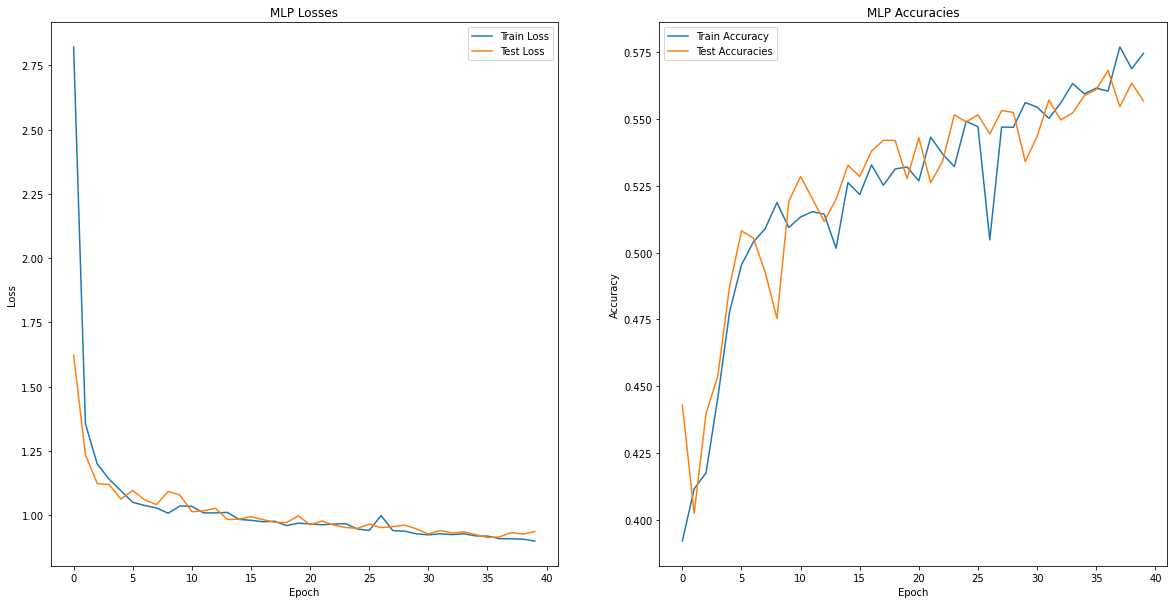

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.flatten()
ax[0].plot(mlp_train_loss, label="Train Loss")
ax[0].plot(mlp_test_loss, label="Test Loss")
ax[0].set_title("MLP Losses")
ax[0].legend(loc='best')
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")

ax[1].plot(mlp_acc_train, label="Train Accuracy")
ax[1].plot(mlp_acc_test, label="Test Accuracies")
ax[1].set_title("MLP Accuracies")
ax[1].legend(loc='best')
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")